In [29]:
import pandas as pd
import os

def calculate_averages(df, place, method):
    # データ範囲を取得
    data = df.values

    sum1, sum2, sum3 = 0, 0, 0
    count_rows = 0
    place_values=[[0.25,-0.1,0],[0.25,0.1,0],[0.5,-0.1,0],[0.5,0.1,0],[0.25,-0.1,-0.1],[0.25,0.1,-0.1],[0.5,-0.1,-0.1],[0.5,0.1,-0.1]]

    # 結果を出力するためのリスト
    results = []
    row_count=0
    for i in range(len(data)):
        # 現在の行が "count" で始まるかチェック
        if isinstance(data[i][0], str) and data[i][0].startswith("count:"):
            if count_rows > 0:
                # 平均値を計算して結果リストに追加
                results.append([
                    row_count,
                    method,
                    place,
                   abs( sum1 / count_rows-place_values[place][0]), 
                    abs(sum2 / count_rows-place_values[place][1]), 
                    abs(sum3 / count_rows-place_values[place][2])                ])
                row_count+=1
            # 次のブロックのために変数をリセット
            sum1, sum2, sum3 = 0, 0, 0
            count_rows = 0
        else:
            # 各列の値を加算
            sum1 += float(data[i][0])
            sum2 += float(data[i][1])
            sum3 += float(data[i][2])
            count_rows += 1

    # 最後のブロックの平均値を計算して追加（ファイルの最後に count: がない場合）
    if count_rows > 0:
        results.append([
            row_count,
            method,
            place,
            abs( sum1 / count_rows-place_values[place][0]), 
            abs(sum2 / count_rows-place_values[place][1]), 
            abs(sum3 / count_rows-place_values[place][2])    
        ])

    return results

# .txtファイルからデータを読み込む
def read_txt_to_dataframe(file_path):
    # ファイルを読み込み、各行をリストに格納
    with open(file_path, 'r', encoding='utf-8-sig') as file:
        lines = file.readlines()

    # 各行をカンマで分割してデータフレームに変換
    data = [line.strip().split(',') for line in lines]

    # データフレームに変換
    df = pd.DataFrame(data)
    return df

# フォルダ内の全ての.txtファイルを処理
def process_all_files_in_folder(folder_path, method):
    results = []
    place = 0
    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):
            file_path = os.path.join(folder_path, filename)
            df = read_txt_to_dataframe(file_path)
            results.extend(calculate_averages(df, place, method)[:5])
            place += 1
    return results

# サンプルフォルダパス
def process_all_folders(folder_path, method):
    # フォルダ内の全ファイルを処理
    results = process_all_files_in_folder(folder_path, method)
    return results

root_path = r"C:\Users\takaharayota\Research\data\0623"
folders_paths = [
    root_path + r"\1exp_withoutsound",
    root_path + r"\1exp_withsound\0",
    root_path + r"\1exp_withsound\1",
    root_path + r"\1exp_withsound\2"
]

# 全てのフォルダを処理し、結果を統合
all_results = []
for i, folder_path in enumerate(folders_paths):
    all_results.extend(process_all_folders(folder_path, i))

# 統合されたデータをデータフレームに変換
columns = ['Subject','Method', 'Place', 'X', 'Y', 'Z']
df_all = pd.DataFrame(all_results, columns=columns)

# データの表示
# DataFrameを.txtファイルに出力
df_all.to_csv('output.txt', sep='\t', index=False)

print("DataFrameの内容がoutput.txtに出力されました。")


DataFrameの内容がoutput.txtに出力されました。


In [30]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm


In [31]:
# X軸に対するANOVA
model_x = ols('X ~ C(Method) + C(Place) + C(Method):C(Place)', data=df_all).fit()
anova_results_x = anova_lm(model_x, typ=2)
print("ANOVA results for X:")
print(anova_results_x)

# Y軸に対するANOVA
model_y = ols('Y ~ C(Method) + C(Place) + C(Method):C(Place)', data=df_all).fit()
anova_results_y = anova_lm(model_y, typ=2)
print("ANOVA results for Y:")
print(anova_results_y)

# Z軸に対するANOVA
model_z = ols('Z ~ C(Method) + C(Place) + C(Method):C(Place)', data=df_all).fit()
anova_results_z = anova_lm(model_z, typ=2)
print("ANOVA results for Z:")
print(anova_results_z)


ANOVA results for X:
                      sum_sq     df          F        PR(>F)
C(Method)           0.013038    3.0  53.761509  1.480686e-22
C(Place)            0.003215    7.0   5.682484  9.842507e-06
C(Method):C(Place)  0.013058   21.0   7.692262  2.419804e-14
Residual            0.010347  128.0        NaN           NaN
ANOVA results for Y:
                      sum_sq     df           F        PR(>F)
C(Method)           0.056346    3.0  233.908294  9.374666e-52
C(Place)            0.013049    7.0   23.215812  4.213683e-20
C(Method):C(Place)  0.017992   21.0   10.669879  2.998667e-19
Residual            0.010278  128.0         NaN           NaN
ANOVA results for Z:
                      sum_sq     df          F        PR(>F)
C(Method)           0.010757    3.0  13.664168  8.679591e-08
C(Place)            0.023143    7.0  12.599119  3.201972e-12
C(Method):C(Place)  0.031574   21.0   5.729713  1.227705e-10
Residual            0.033589  128.0        NaN           NaN


In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# TukeyのHSDテストを実行する関数
def perform_tukeyhsd(df, dependent_var):
    tukey = pairwise_tukeyhsd(endog=df[dependent_var],
                              groups=df['Method'].astype(str) + '_' + df['Place'].astype(str),
                              alpha=0.05)
    return tukey

# TukeyのHSDテストの結果を表示
print("Tukey HSD for X:")
print(perform_tukeyhsd(df_all, 'X'))

print("\nTukey HSD for Y:")
print(perform_tukeyhsd(df_all, 'Y'))

print("\nTukey HSD for Z:")
print(perform_tukeyhsd(df_all, 'Z'))


Tukey HSD for X:
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0_0    0_1  -0.0126 0.9346 -0.0346  0.0094  False
   0_0    0_2   0.0272 0.0019  0.0052  0.0492   True
   0_0    0_3   0.0101 0.9963 -0.0119  0.0321  False
   0_0    0_4   0.0317 0.0001  0.0097  0.0537   True
   0_0    0_5   0.0108 0.9902 -0.0112  0.0328  False
   0_0    0_6  -0.0047    1.0 -0.0267  0.0173  False
   0_0    0_7  -0.0086 0.9998 -0.0306  0.0135  False
   0_0    1_0  -0.0169 0.4473 -0.0389  0.0051  False
   0_0    1_1  -0.0172 0.4093 -0.0392  0.0048  False
   0_0    1_2  -0.0189 0.2202 -0.0409  0.0031  False
   0_0    1_3  -0.0178 0.3347 -0.0398  0.0042  False
   0_0    1_4  -0.0177 0.3498 -0.0397  0.0043  False
   0_0    1_5   -0.018 0.3148   -0.04   0.004  False
   0_0    1_6  -0.0153 0.6609 -0.0373  0.0067  False
   0_0    1_7  -0.0172 0.4025 -0.0392  0.0048  False
   0_0    2_0   0.0031    1.0

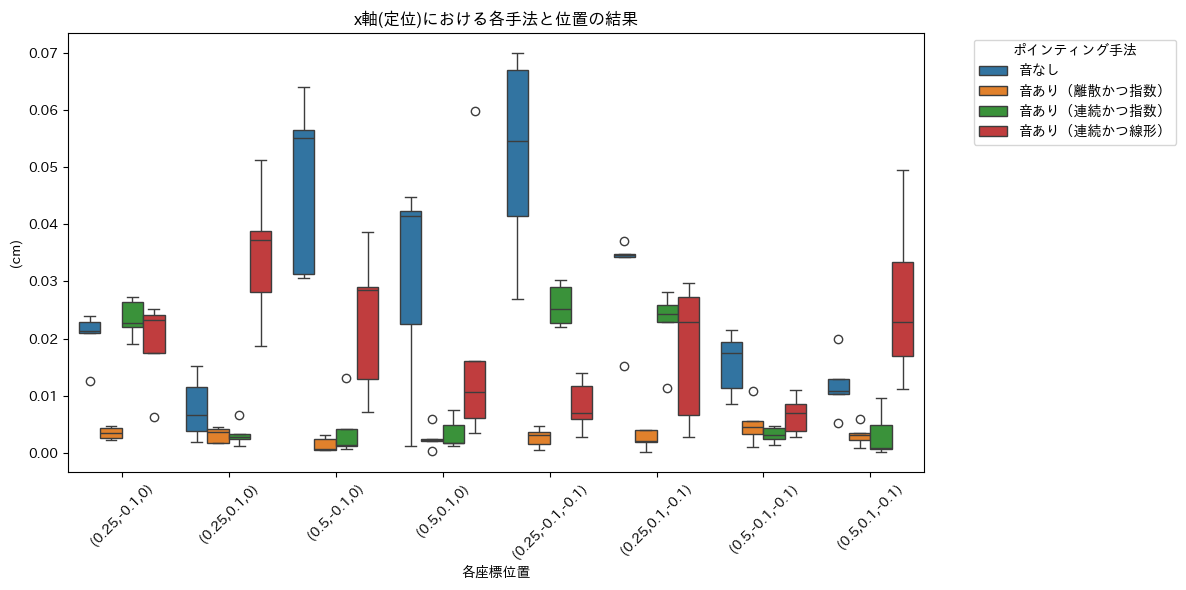

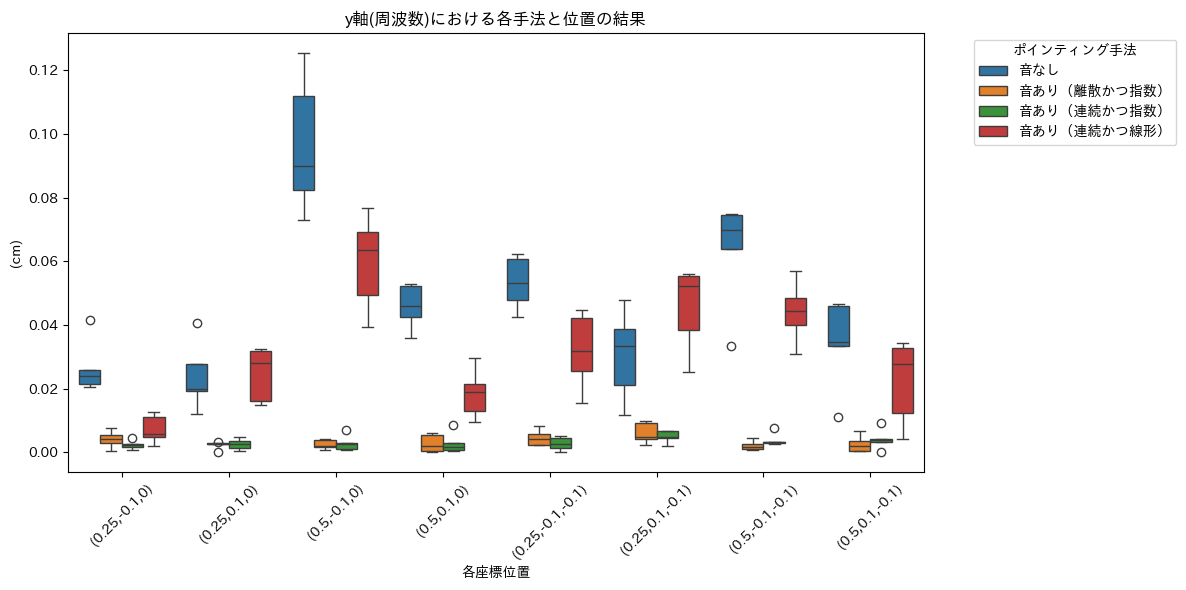

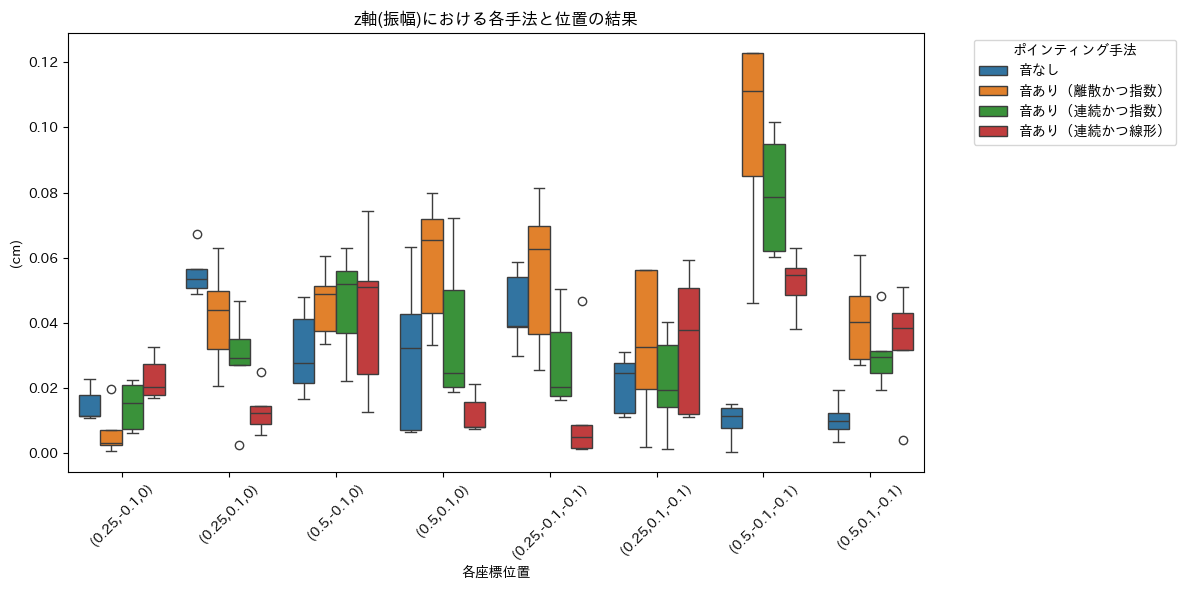

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

# データフレームの例
# df_all = pd.DataFrame(...)

# Method と Place の具体的な意味をラベルに追加する
method_labels = {
    0: '音なし',
    1: '音あり（離散かつ指数）',
    2: '音あり（連続かつ指数）',
    3: '音あり（連続かつ線形）'
}

place_labels = {
    0: '(0.25,-0.1,0)',
    1: '(0.25,0.1,0)',
    2: '(0.5,-0.1,0)',
    3: '(0.5,0.1,0)',
    4: '(0.25,-0.1,-0.1)',
    5: '(0.25,0.1,-0.1)',
    6: '(0.5,-0.1,-0.1)',
    7: '(0.5,0.1,-0.1)'
}

# Method と Place のラベルをデータフレームに追加
df_all['Method_Label'] = df_all['Method'].map(method_labels)
df_all['Place_Label'] = df_all['Place'].map(place_labels)

# 可視化
plt.figure(figsize=(12, 6))
sns.boxplot(x='Place_Label', y='X', hue='Method_Label', data=df_all)
plt.title('x軸(定位)における各手法と位置の結果')
plt.xlabel('各座標位置')
plt.ylabel('(cm)')
plt.legend(title='ポインティング手法', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='Place_Label', y='Y', hue='Method_Label', data=df_all)
plt.title('y軸(周波数)における各手法と位置の結果')
plt.xlabel('各座標位置')
plt.ylabel('(cm)')
plt.legend(title='ポインティング手法', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='Place_Label', y='Z', hue='Method_Label', data=df_all)
plt.title('z軸(振幅)における各手法と位置の結果')
plt.xlabel('各座標位置')
plt.ylabel('(cm)')
plt.legend(title='ポインティング手法', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd


method_labels = {
    0: '0',
    1: '1',
    2: '2',
    3: '3'
}
# Method と Place のラベルをデータフレームに追加
df_all['Method_Label'] = df_all['Method'].map(method_labels)
# データフレームから必要な列を抽出
method_data = df_all[['Method_Label', 'X', 'Y', 'Z']]


# TukeyのHSDテストを実行する関数
def perform_tukeyhsd_for_method(df, dependent_var):
    tukey = pairwise_tukeyhsd(endog=df[dependent_var],
                              groups=df['Method_Label'].astype(str),
                              alpha=0.05)
    return tukey

# TukeyのHSDテストの結果を表示
print("Tukey HSD for X:")
print(perform_tukeyhsd_for_method(method_data, 'X'))

print("\nTukey HSD for Y:")
print(perform_tukeyhsd_for_method(method_data, 'Y'))

print("\nTukey HSD for Z:")
print(perform_tukeyhsd_for_method(method_data, 'Z'))




Tukey HSD for X:
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1  -0.0241    0.0 -0.0317 -0.0165   True
     0      2   -0.016    0.0 -0.0236 -0.0084   True
     0      3  -0.0076 0.0498 -0.0152    -0.0   True
     1      2   0.0081 0.0303  0.0006  0.0157   True
     1      3   0.0165    0.0  0.0089  0.0241   True
     2      3   0.0084 0.0239  0.0008   0.016   True
----------------------------------------------------

Tukey HSD for Y:
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1  -0.0435    0.0 -0.0529  -0.034   True
     0      2  -0.0436    0.0  -0.053 -0.0341   True
     0      3  -0.0151 0.0003 -0.0245 -0.0056   True
     1      2  -0.0001    1.0 -0.0095  0.0094  False
     1      3   0.0284    0.0   0.019  0.0379   True
     2     

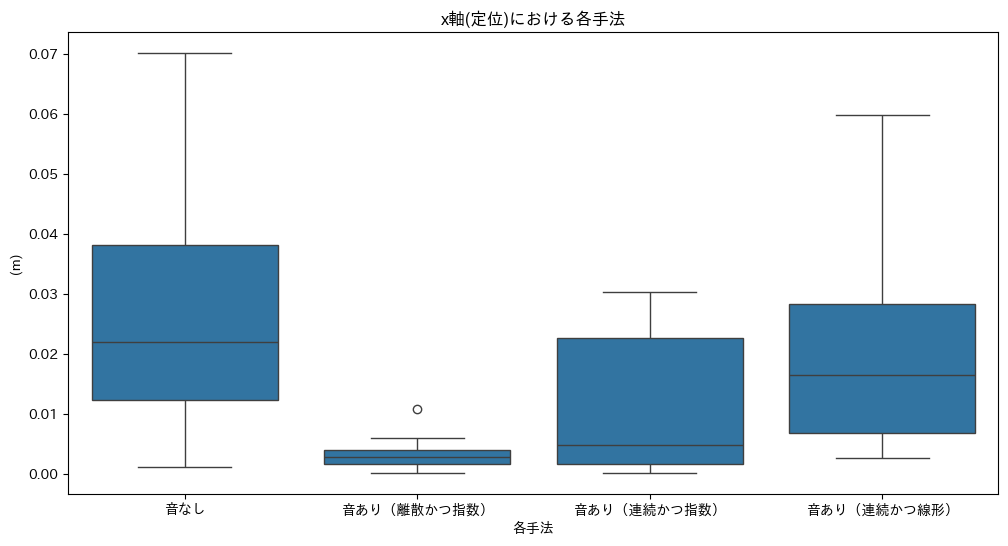

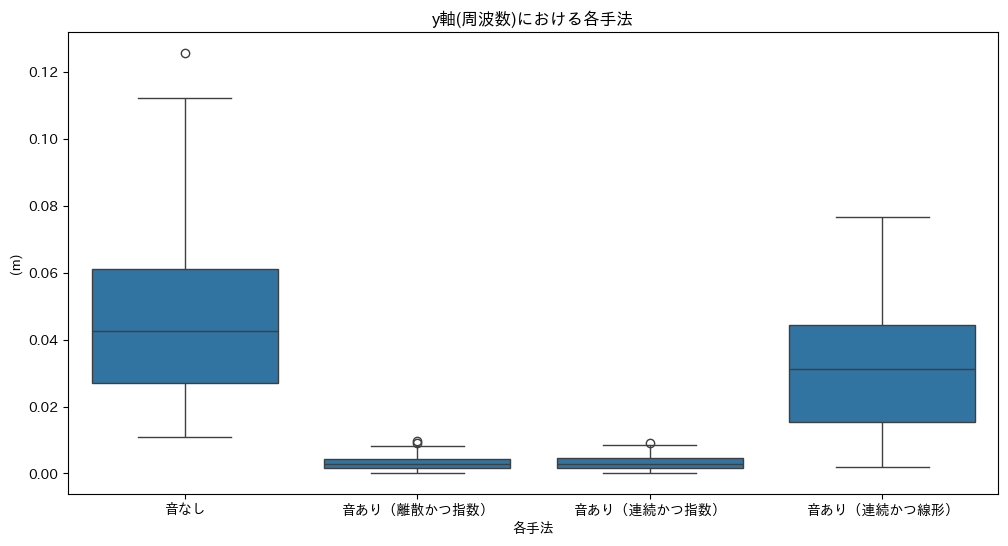

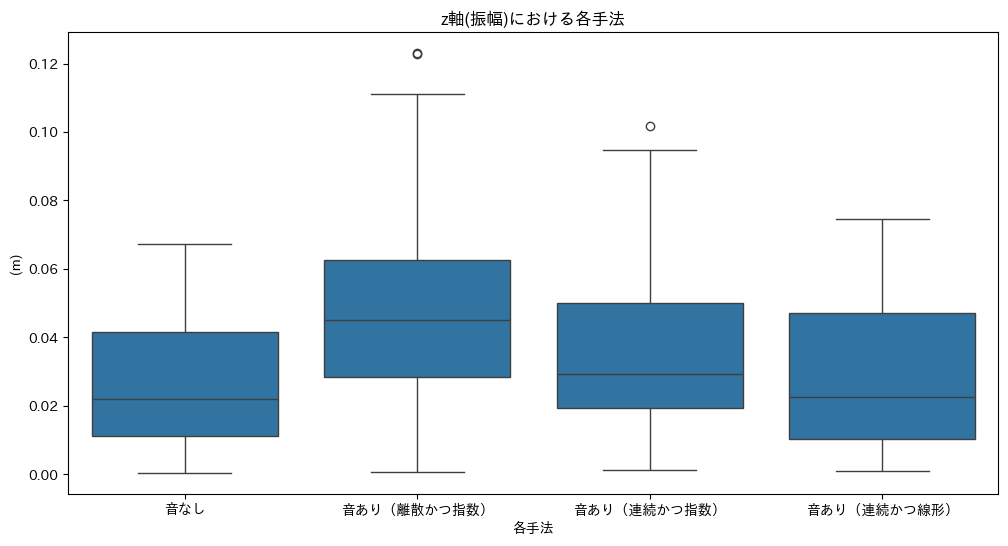

In [15]:
# 可視化
plt.figure(figsize=(12, 6))
sns.boxplot(x='Method_Label', y='X', data=method_data)
plt.title('x軸(定位)における各手法')
plt.xlabel('各手法')
plt.ylabel('(m)')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='Method_Label', y='Y', data=method_data)
plt.title('y軸(周波数)における各手法')
plt.xlabel('各手法')
plt.ylabel('(m)')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='Method_Label', y='Z', data=method_data)
plt.title('z軸(振幅)における各手法')
plt.xlabel('各手法')
plt.ylabel('(m)')
plt.show()

In [20]:
from statsmodels.multivariate.manova import MANOVA
manova = MANOVA.from_formula('X+Y+Z~Method+Place+Method:Place',data=df_all)
manova_result=manova.mv_test()
print(manova_result)
# 結果をファイルに保存
with open('manova_results.txt', 'w') as file:
    file.write(str(manova_result))

                  Multivariate linear model
                                                             
-------------------------------------------------------------
       Intercept        Value  Num DF  Den DF  F Value Pr > F
-------------------------------------------------------------
          Wilks' lambda 0.6361 3.0000 154.0000 29.3687 0.0000
         Pillai's trace 0.3639 3.0000 154.0000 29.3687 0.0000
 Hotelling-Lawley trace 0.5721 3.0000 154.0000 29.3687 0.0000
    Roy's greatest root 0.5721 3.0000 154.0000 29.3687 0.0000
-------------------------------------------------------------
                                                             
-------------------------------------------------------------
         Method         Value  Num DF  Den DF  F Value Pr > F
-------------------------------------------------------------
          Wilks' lambda 0.9356 3.0000 154.0000  3.5324 0.0163
         Pillai's trace 0.0644 3.0000 154.0000  3.5324 0.0163
 Hotelling-Lawley trace 0.

In [25]:

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import MultiComparison

# FisherのLSD検定の実行
def fisher_lsd(df, dependent_var, factor):
    mc = MultiComparison(df[dependent_var], df[factor])
    result = mc.allpairtest(sm.stats.ttest_ind, method='bonf')[0]
    return result

# X, Y, Z それぞれに対して FisherのLSD検定を実施
print("Fisher LSD for X:")
fisher_x = fisher_lsd(df_all, 'X', 'Method')
print(fisher_x)

print("\nFisher LSD for Y:")
fisher_y = fisher_lsd(df_all, 'Y', 'Method')
print(fisher_y)

print("\nFisher LSD for Z:")
fisher_z = fisher_lsd(df_all, 'Z', 'Method')
print(fisher_z)

with open('fisher-LSD_results-X.txt', 'w') as file:
    file.write(str(fisher_x))

with open('fisher-LSD_results-Y.txt', 'w') as file:
    file.write(str(fisher_y))

with open('fisher-LSD_results-Z.txt', 'w') as file:
    file.write(str(fisher_z))



Fisher LSD for X:
Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.01, alphacBonf=0.008
group1 group2   stat   pval  pval_corr reject
---------------------------------------------
     0      1  8.1017    0.0       0.0   True
     0      2  4.6847    0.0    0.0001   True
     0      3  2.0222 0.0466    0.2795  False
     1      2 -4.7138    0.0    0.0001   True
     1      3 -7.0875    0.0       0.0   True
     2      3 -2.9275 0.0045    0.0269   True
---------------------------------------------

Fisher LSD for Y:
Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.01, alphacBonf=0.008
group1 group2   stat   pval  pval_corr reject
---------------------------------------------
     0      1  10.455    0.0       0.0   True
     0      2 10.4807    0.0       0.0   True
     0      3   2.947 0.0042    0.0254   True
     1      2  0.1514 0.8801       1.0  False
     1      3 -9.3607    0.0       0.0   True
     2      3 -9.3978    0.0       0.0   

LSD results for X:
 Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.01, alphacBonf=0.008
group1 group2   stat   pval  pval_corr reject
---------------------------------------------
     0      1  8.1017    0.0       0.0   True
     0      2  4.6847    0.0    0.0001   True
     0      3  2.0222 0.0466    0.2795  False
     1      2 -4.7138    0.0    0.0001   True
     1      3 -7.0875    0.0       0.0   True
     2      3 -2.9275 0.0045    0.0269   True
---------------------------------------------


AttributeError: 'SimpleTable' object has no attribute 'plot_simultaneous'